# Demonstration of Omnistereo Sensor Implementation

In [8]:
# Imports for plotting and image display
from IPython.display import Image, display
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpldatacursor import datacursor, HighlightingDataCursor

from IPython.display import Image
import numpy as np
from sympy import Matrix, ImmutableMatrix
import os.path as osp
from omnistereo import common_tools
from omnistereo.common_cv import has_opencv
opencv_exists = has_opencv()

## Synthetic Model

In [9]:
# Setup:
#===========================================================================
# vvvvvvvvvvvvvvvvvvvvvvv OPTIONS vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
is_synthetic = True
show_panoramic_img = True
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# vvvvvvvvvvvvvvvvvvvvvvv SETUP vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#omnistereo_path = osp.relpath(common_tools.__file__)
data_root = "data" # The root folder for all data
model_version = "old"  # Set to "old" for the PUBLISHED params
if is_synthetic:
    model_type = "synthetic"
else:
    model_type = "real"
data_path_prefix = osp.join(data_root, model_type, model_version)
experiment_name = "office"
experiment_path = osp.join(data_path_prefix, experiment_name)  # Pose estimation experiment: Translation on x only by 0, 25 cm and 75 cm (wrt init)

# For SHOWING OFF: virtual office
omni_img_filename_template = osp.join(experiment_path, "office-%s-*.png" % (model_version))  # With PUBLISHED parameters
# omni_img_filename_template = osp.join(data_path_prefix, experiment_path, "office" + model_version + "-*.png")  # NEW design
img_indices = []  # Choosing a predefined set of images to work with out of the set
img_index = 0  # <<<<<------ Choosing an arbitrary image to work with out of the set
# ------------------------------------------------
omnistereo_model_filename = osp.join(data_path_prefix, "omnistereo-hyperbolic.pkl")
# ------------------------------------------------
radial_bounds_filename = osp.join(data_path_prefix, "radial_bounds.pkl")  
# ------------------------------------------------
points_3D_filename_template = osp.join(experiment_path, "3d_points-" + model_version + "-*.pkl")
# Read params from file and scale to [mm] units since using [cm] (only those params with dimensions)
theoretical_params_filename = osp.join(data_root, "parameters-%s.txt" % (model_version))

Reading data/synthetic/old/office/office-old-0.png...success


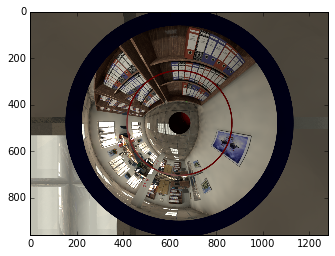

Loading obj_instance instance from pickle file data/synthetic/old/omnistereo-hyperbolic.pkl ... done!


In [10]:
from omnistereo.common_cv import get_images
omni_images_list = get_images(omni_img_filename_template, indices_list=img_indices, show_images=False)
if has_opencv:
    from omnistereo.common_cv import get_cv_img_as_RGB
    omni_img_rgb = get_cv_img_as_RGB(omni_images_list[img_index])
    fig = plt.figure(figsize=(6,4))
    ax=fig.add_subplot(1,1,1)
    plt.imshow(omni_img_rgb)
    plt.show()

omnistereo_model = common_tools.load_obj_from_pickle(omnistereo_model_filename)

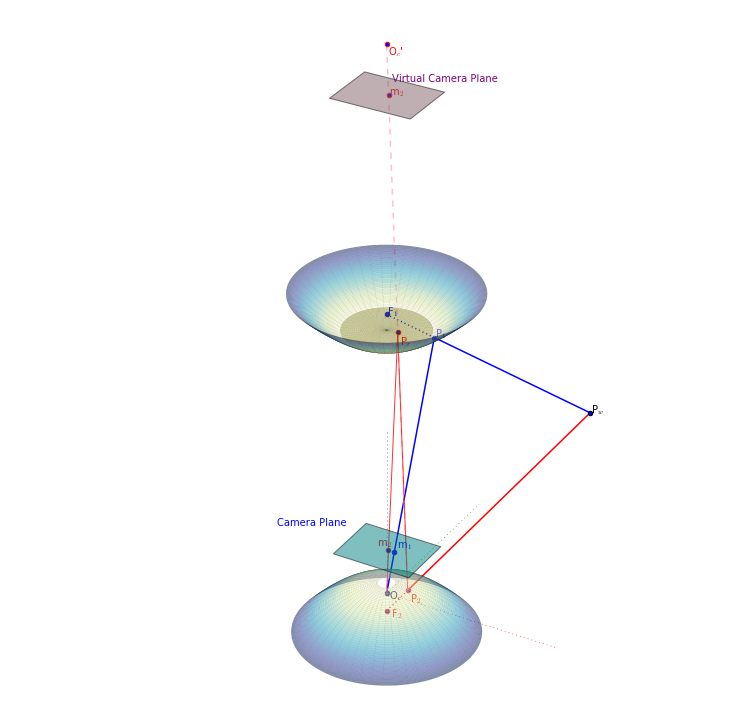

In [11]:
xw, yw, zw = 80, 10 , 100
# Pw = [(xw, yw, zw), (-xw, yw, zw), (xw, -yw, zw), (-xw, -yw, zw)]
Pw = [(xw, yw, zw)]
from omnistereo.common_plot import draw_fwd_projection_omnistereo
draw_fwd_projection_omnistereo(omnistereo_model, Pw, verbose=False, fig_size=(10,10))

**Figure 4.** Omnistereo projection of a 3D point $\mathrm{P}_w$ to obtain image points $^{\left[ {{{\text{I}}}} \right]}{{\mathbf{m}}_1}$ and $^{\left[ {{{\text{I}}}} \right]}{{\mathbf{m}}_2}$.

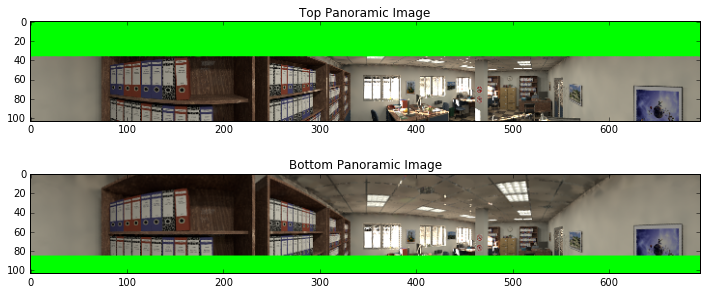

In [12]:
if show_panoramic_img and opencv_exists:
    #omnistereo_model.view_all_panoramas(omni_img_filename_template, img_indices, win_name_modifier=pano_win_name_prefix, use_mask=True, mask_color_RGB=(0, 255, 0))
    pano_img_top, pano_img_bot = omnistereo_model.generate_panorama_pair(omni_img=omni_images_list[img_index], idx=img_index, view=False, win_name_modifier="", border_RGB_color=(0,255,0))
    # Convert panoramic images to RGB:
    pano_img_top_rgb = get_cv_img_as_RGB(pano_img_top)
    pano_img_bot_rgb = get_cv_img_as_RGB(pano_img_bot)
    # Display images
    fig = plt.figure(figsize=(12,5))
    ax=fig.add_subplot(2,1,1)
    imgplot = plt.imshow(pano_img_top_rgb)
    ax.set_title('Top Panoramic Image')
    #plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation ='horizontal')
    ax=fig.add_subplot(2,1,2)
    imgplot = plt.imshow(pano_img_bot_rgb)
    #imgplot.set_clim(0.0,0.7)
    ax.set_title('Bottom Panoramic Image')
    #plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation='horizontal')

## Real-Life Model

In [13]:
# RESET settings for real-life model:
# vvvvvvvvvvvvvvvvvvvvvvv OPTIONS vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
is_synthetic = False
if is_synthetic:
    model_type = "synthetic"
else:
    model_type = "real"
data_path_prefix = osp.join(data_root, model_type, model_version)
experiment_name = "office"
experiment_path = osp.join(data_path_prefix, experiment_name)  # Pose estimation experiment: Translation on x only by 0, 25 cm and 75 cm (wrt init)

# For SHOWING OFF: virtual office
omni_img_filename_template = osp.join(experiment_path, "office-%s-*.png" % (model_version))  # With PUBLISHED parameters
# omni_img_filename_template = osp.join(data_path_prefix, experiment_path, "office" + model_version + "-*.png")  # NEW design
img_indices = []  # Choosing a predefined set of images to work with out of the set
img_index = 0  # <<<<<------ Choosing an arbitrary image to work with out of the set
# ------------------------------------------------
omnistereo_model_filename = osp.join(data_path_prefix, "omnistereo-hyperbolic.pkl")
# ------------------------------------------------
radial_bounds_filename = osp.join(data_path_prefix, "radial_bounds.pkl")  
# ------------------------------------------------
points_3D_filename_template = osp.join(experiment_path, "3d_points-" + model_version + "-*.pkl")
# Read params from file and scale to [mm] units since using [cm] (only those params with dimensions)
theoretical_params_filename = osp.join(data_root, "parameters-%s.txt" % (model_version))

Reading data/real/old/office/office-old-0.png...success
Reading data/real/old/office/office-old-1.png...success


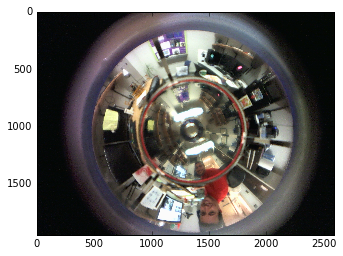

Loading obj_instance instance from pickle file data/real/old/omnistereo-hyperbolic.pkl ... done!


In [14]:
from omnistereo.common_cv import get_images
omni_images_list = get_images(omni_img_filename_template, indices_list=img_indices, show_images=False)
if has_opencv:
    from omnistereo.common_cv import get_cv_img_as_RGB
    omni_img_rgb = get_cv_img_as_RGB(omni_images_list[img_index])
    fig = plt.figure(figsize=(6,4))
    ax=fig.add_subplot(1,1,1)
    plt.imshow(omni_img_rgb)
    plt.show()

omnistereo_model = common_tools.load_obj_from_pickle(omnistereo_model_filename)

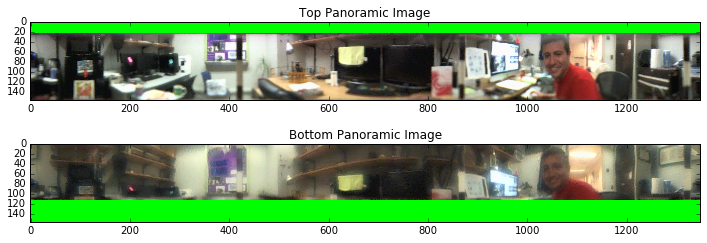

In [15]:
if show_panoramic_img and opencv_exists:
    #omnistereo_model.view_all_panoramas(omni_img_filename_template, img_indices, win_name_modifier=pano_win_name_prefix, use_mask=True, mask_color_RGB=(0, 255, 0))
    pano_img_top, pano_img_bot = omnistereo_model.generate_panorama_pair(omni_img=omni_images_list[img_index], idx=img_index, view=False, win_name_modifier="", border_RGB_color=(0,255,0))
    # Convert panoramic images to RGB:
    pano_img_top_rgb = get_cv_img_as_RGB(pano_img_top)
    pano_img_bot_rgb = get_cv_img_as_RGB(pano_img_bot)
    # Display images
    fig = plt.figure(figsize=(12,4))
    ax=fig.add_subplot(2,1,1)
    imgplot = plt.imshow(pano_img_top_rgb)
    ax.set_title('Top Panoramic Image')
    #plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation ='horizontal')
    ax=fig.add_subplot(2,1,2)
    imgplot = plt.imshow(pano_img_bot_rgb)
    #imgplot.set_clim(0.0,0.7)
    ax.set_title('Bottom Panoramic Image')
    #plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation='horizontal')

In [16]:
#from omnistereo.common_plot import draw_omnistereo_model_visvis
#draw_omnistereo_model_visvis(omnistereo_model, finish_drawing=True, show_grid_box=False, mirror_transparency=0.5, show_reference_frame=True)

In [17]:
# TODO: VisPy not working with webGL backend in version 4.
# load the vispy bindings for the IPython notebook which enables webGL
# %load_ext vispy.ipython
#from omnistereo.common_plot import draw_omnistereo_model_vispy
#draw_omnistereo_model_vispy(omnistereo_model, show_grid=True, backend='ipynb_webgl')

## 2D Plots for Analysis

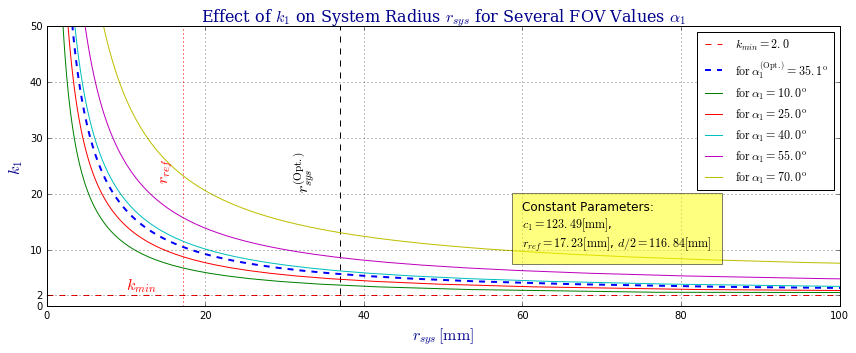

In [18]:
from omnistereo.common_plot import plot_k_vs_rsys_for_vFOV
plot_k_vs_rsys_for_vFOV(omnistereo_model.top_model,fig_size=(12, 5)) 

**Figure 9.** The effect that parameter $k_i$ (showing mirror 1
    only) has over the system radius $r_{sys}$ for various values of the vertical field of
    view angle $\alpha_1$. In order to maintain a vertical field of
    view $\alpha_i$ that is bounded by $z_{max}\mid_{r_{sys}}$, the value of $r_{sys}$ must
    change accordingly.
    Inherently,
    the system's height, $h_{sys}$, and its mass, $m_{sys}$, are also affected by $k_i$
    (see Section~2.3 in article). 

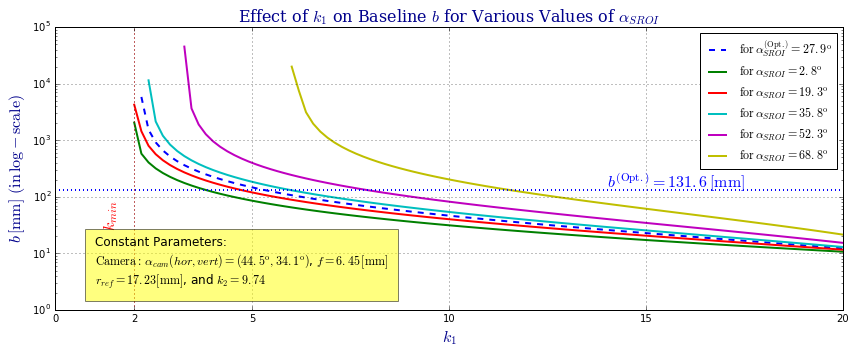

In [19]:
from omnistereo.common_plot import plot_k_vs_baseline_for_vFOV
plot_k_vs_baseline_for_vFOV(omnistereo_model, fig_size=(12, 5))

**Figure 10.** The effect that parameter $k_1$ has over the omnistereo system's baseline $b$ for several common FOV angles ($\alpha_{SROI}$) and a fixed camera with $\alpha_{cam}$.
An inverse relationship exists between $k$ and $b$ as plotted here (using a logarithmic scale for the vertical axis). Intuitively, the flatter the mirror gets ($k \to 2$), the farther $\mathrm{F}_1$ must be translated in order to fit within the camera's view, $\alpha_{SROI}$ , causing $b$ to increase.

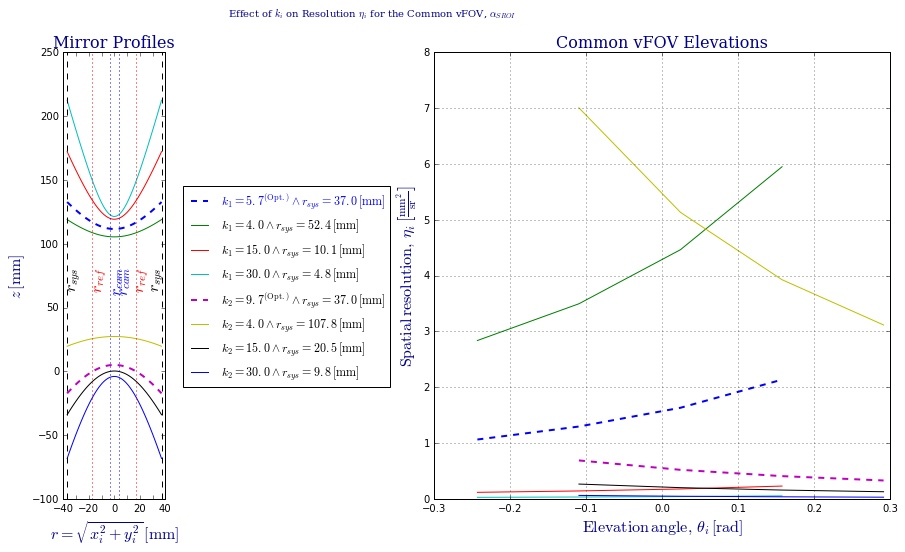

In [20]:
from omnistereo.common_plot import plot_catadioptric_spatial_resolution_vs_k
plot_catadioptric_spatial_resolution_vs_k(omnistereo_model, fig_size=(18,8), legend_location=(-0.55, 0.25))

**Figure 11.** Comparison of $k_i$ values and their effect on spatial resolution $\eta_i$ for $i=\{1,2\}$. For the big rig, the optimal focal dimensions $c_1$ and $c_2$ (from Table 1) were used as well as the angular span on the common vertical FOV, $\alpha_{SROI} \approx 28^{\circ}$. Although resolution $\eta_{i}^{(Opt.)}$ for the optimal values of $k_i$ could be improved by employing smaller $k$ values (lower curvature profiles indicated on the left plot of the figure), this would in turn increase the system radius, $r_{sys}$, as to maintain $\alpha_i$ (Figure 9).
As expected, the plot on the right help us appreciate how the spatial resolutions, $\eta_i$,
increase towards the equatorial regions ($\theta_1 \to \theta_{SROI,max}$ and $\theta_2 \to
\theta_{SROI,min}$).

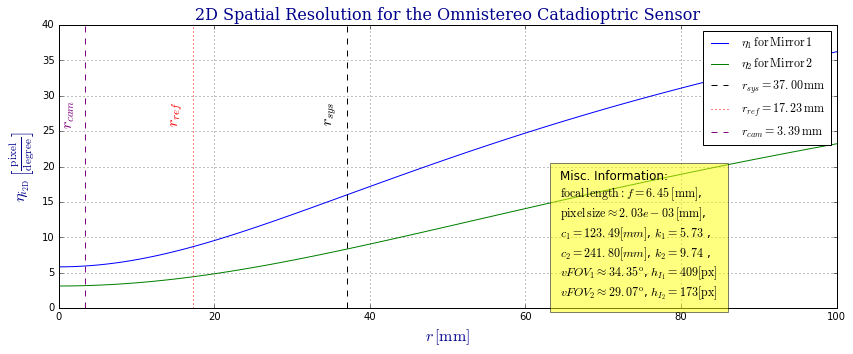

In [21]:
from omnistereo.common_plot import plot_catadioptric_spatial_resolution
plot_catadioptric_spatial_resolution(omnistereo_model, in_2D=True, eta_max=18, fig_size=(12,5))

**Figure 12.** Using the formula given in Equation~(60), we plot the 2D version of the spatial resolution of our
    proposed omnistereo catadioptric sensor (37 mm-radius rig). 
    Both resolutions $\eta_1$ and $\eta_2$ increase towards the equatorial region where they are
    physically limited by $r_{sys}$. This verifies the spatial resolution theory given in
    by Baker and Naya in 1999, and it justifies our coaxial configuration useful for omnistereo sensing
    within the SROI indicated in Figure 6 (in manuscript).

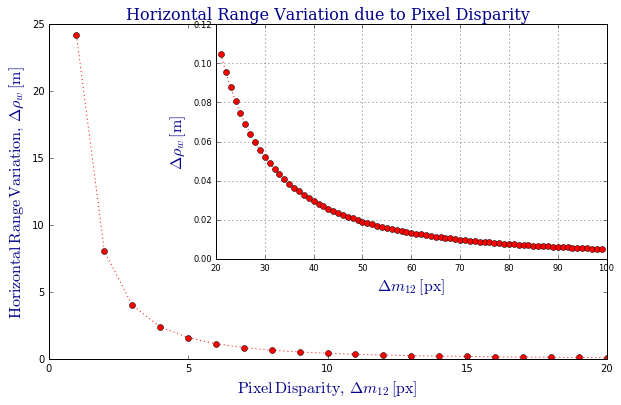

In [22]:
from omnistereo.common_plot import plot_range_variation_due_to_pixel_disparity
plot_range_variation_due_to_pixel_disparity(omnistereo_model, disp_min=1, disp_max=100, fig_size=(10,6))

**Figure 17.** Variation of horizontal range, $\Delta \rho_w$, due to change in pixel disparity $\Delta m_{12}$ on the omnidirectional image, $\left[\mathrm{I}\right]$.
There exists a ``nonlinear \& inverse'' relation between the change in depth from triangulation ($\Delta \rho_w$) and the number of disparity pixels ($\Delta m_{12}$) available from the omnistereo image pair $\left(\left[\mathrm{I}_1\right],\left[\mathrm{I}_2\right]\right)$, which are exclusive subspaces of $\left[\mathrm{I}\right]$.